<a href="https://colab.research.google.com/github/nickzherdev/useful_notebooks/blob/master/Omni_Movement_Arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Robot is operated as material point.
x, y coordinates and orientation theta of robot in WCF are known, x_goal, y_goal, theta_goal

At each timestep, the robot finds the proper look ahead point,  calculates the curvature and velocity needed to get to that point, 

In [0]:
from IPython.display import Image, HTML
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
from random import random
from matplotlib.animation import FuncAnimation

In [0]:
def transformation_matrix(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])

def wrap_angle(angle):
    """
    Wraps the given angle to the range [-pi, +pi] to prevent unstable behavior 
    e.g. difference going from 0 rad to 2*pi rad with slight turn.

    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [0]:
def plot_vehicle(x, y, theta):
    # Corners of triangular vehicle when pointing to the right (0 radians)

    p1_i = np.array([0.5, 0, 1]).T
    p2_i = np.array([-0.5, 0.25, 1]).T
    p3_i = np.array([-0.5, -0.25, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)

    ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-')
    ax1.plot([p2[0], p3[0]], [p2[1], p3[1]], 'k-')
    ax1.plot([p3[0], p1[0]], [p3[1], p1[1]], 'k-')

def plot_trajectory(x_traj, y_traj):
    ax1.plot(x_traj, y_traj, 'b--')

def plot_goal():
    ax1.arrow(x_start, y_start, np.cos(theta_start),
          np.sin(theta_start), color='r', width=0.1)
    ax1.arrow(x_goal, y_goal, np.cos(theta_goal),
          np.sin(theta_goal), color='g', width=0.1)

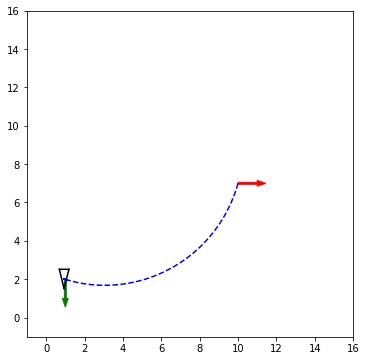

In [9]:
start = [10, 7, 2*np.pi]
goal = [1, 2, 3*np.pi/2]

x_start, y_start, theta_start = start[0], start[1], start[2]
x_goal, y_goal, theta_goal = goal[0], goal[1], goal[2]
x_traj, y_traj, theta_hist = [x_start, ], [y_start, ], [theta_start, ]
Kp_rho = 15
dt = 0.01

#w = 1.5

# def initialize_variables(start, goal):

# create an output with an empty figure
fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.set_aspect('equal')
ax1.set(xlim=(-1, 16), ylim=(-1, 16))
line, = ax1.plot([],[])

def get_robot_position():
    x = x_traj[-1]
    y = y_traj[-1]
    theta = theta_hist[-1]
    return x, y, theta

def calculate_next_position(x, y, theta):
    x_diff = x_goal - x
    y_diff = y_goal - y

    gamma = np.arctan2(y_diff, x_diff)
    d = np.sqrt(x_diff**2 + y_diff**2) # rho, np.linalg.norm(d_map_frame[:2])

    alpha = wrap_angle(theta_goal - theta) # theta_diff

    v = Kp_rho  # * d
    
    if alpha == 0:
        w = 0
    else:
        R = 0.5 * d / np.sin(alpha/2)
        w = v / R  # must be depended on v such way so path becomes an arc

    beta = wrap_angle(gamma - alpha/2)

    vx = v * np.cos(beta)
    vy = v * np.sin(beta)
    
    theta += w * dt
    x += vx * dt
    y += vy * dt

    return x, y, theta

def record_trajectory(x, y, theta):
    x_traj.append(x)
    y_traj.append(y)
    theta_hist.append(theta)

def animate(i):

    """perform animation step"""

    # global x_goal, y_goal, theta_goal, x_traj, y_traj, theta_hist, dt

    ax1.cla()
    ax1.set_aspect('equal')
    ax1.set(xlim=(-1, 16), ylim=(-1, 16))

    x, y, theta = get_robot_position()

    plot_vehicle(x, y, theta)
    plot_trajectory(x_traj, y_traj)
    plot_goal()

    x, y, theta = calculate_next_position(x, y, theta)
    record_trajectory(x, y, theta)

    line.set_data(x, y)

ani_arc = FuncAnimation(fig, animate, interval = 10, frames=100);
ani_arc